# Tutorial on Propensity Score Matching with Dowhy to de-bias causal estimates

In this notebook we introduce the use of propensity score methods as provided by Microsoft's DoWhy library to estimate the magnitude of causal effects.

We illustrate this by estimating the effect of a subscription or rewards programme (*treatment*) on customer spend (*outcome*).

Suppose that a website has a membership rewards program where customers receive additional benefits if they sign up. How do we know if the program is effective? At the end of the day, it may just be the more engaged customers are also those that sign up for the program!

Hence, the relevant causal question is:
> What is the impact of offering the membership rewards program on total sales?

And the equivalent counterfactual question is, 
> If the current members had not signed up for the program, how much less would they have spent on the website?

In language of causal inference, we are interested in the *Average Treatment Effect on the Treated* (ATT):

𝐴𝑇𝑇=𝐸[𝑌(𝑇=1)−𝑌(𝑇=0)|𝑇=1]=𝐸[𝑌(𝑇=1)|𝑇=1]−𝐸[𝑌(𝑇=0)|𝑇=1]

Note the counterfactual nature of both this causal effect:
- the first term on the right hand side is the average spend by members of the programme (T=1), a potentially observable quantity;
- the second term is the average spend by non-members *had they been members*: this cannot be observed, though we may have a control group or modelling strategy that provides a consistent estimate.

### Load packages and set debugging level

In [3]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

# install dowhy
import sys
!{sys.executable} -m pip install dowhy
import dowhy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 123 kB 5.1 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


In [4]:
# install libgraphviz and pygraphviz for nicer-looking graphs:
!apt install libgraphviz-dev
import sys
!{sys.executable} -m pip install pygraphviz
import pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk libxdot4
0 upgraded, 8 newly installed, 0 to remove and 37 not upgraded.
Need to get 2,120 kB of archives.
After this operation, 7,128 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-common all 2.24.32-1ubuntu1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgtk2.0-0 amd64 2.24.32-1ubuntu1 [1,769 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail18 amd64 2.24.32-1ubuntu1 [14.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/main amd64 libgail-common amd64 2.24.32

## Creating a synthetic dataset

Suppose that the rewards program was introduced in January 2019. The `outcome` variable is the total spends at the end of the year. We have data on all monthly transactions of every user and on the time of signup for those who chose to signup for the rewards program. Here’s what the data looks like:


In [76]:
# initialize a random number generator with given seed for reproducibility:
from numpy.random import Generator, PCG64
random_seed = 42 #123456
#random_seed = 123456
rng = Generator(PCG64(random_seed))
#rng = np.random.default_rng(random_seed)

stratum = {'1': 
           {'num': 100,
             'age': 26,
             'age-std': 4 , #*0.5,
             'sex-pc': 0.52,
             'ate': -0.13,
             'view': 0.30},
           '2': 
           {'num': 100,
             'age': 32,
             'age-std': 3 , #*0.5,
             'sex-pc': 0.54,
             'ate': -0.10,
             'view': 0.33},
           '3': 
           {'num': 100,
             'age': 40,
             'age-std': 3 , #*0.5,
             'sex-pc': 0.52,
             'ate': -0.05,
             'view': 0.33},
           '4':
           {'num': 150,
             'age': 55,
             'age-std': 5 , #*0.5,
             'sex-pc': 0.54,
             'ate': 0.22,
             'view': 0.28}
}

df = pd.DataFrame(columns=['age', 'sex', 'cover', 'viewed'])

for idx in range(1,1+len(stratum)):
    strat = stratum[str(idx)]
    num = strat['num']
    age = strat['age']
    std = strat['age-std']
    sex_pc = strat['sex-pc']
    ate = strat['ate']
    view = strat['view']

    ages = rng.normal(loc=age, scale=std, size=num).astype(float)
    sexes = rng.binomial(n=1, p=sex_pc, size=num).astype(float)
    covers = rng.binomial(n=1, p=0.5, size=num) # random treatment within stratum!
    len1 = covers.sum()
    len0 = len(covers)-len1
    views_0 = rng.binomial(n=1, p=view-0.5*ate, size=len0)
    views_1 = rng.binomial(n=1, p=view+0.5*ate, size=len1)
    df_strat = pd.DataFrame(
        data={'age': ages, 'sex': sexes, 'cover': covers, 'strat': idx})
    df_strat.loc[ df_strat['cover']==0, 'viewed' ] = views_0
    df_strat.loc[ df_strat['cover']==1, 'viewed' ] = views_1
    df = df.append(df_strat, ignore_index=True)
    print(idx, df.shape)

display( df.sample(n=4) )
display( df.describe() )

print("Mean values per stratum:")
display( df.groupby('strat').mean() ) #(['min', 'mean', 'max']) )

print("Mean values per cover:")
display( df.groupby('cover').mean() ) #(['min', 'mean', 'max']) )

1 (100, 5)
2 (200, 5)
3 (300, 5)
4 (450, 5)


,age,sex,cover,viewed,strat
164,37.853038,0.0,1,0.0,2.0
442,64.181129,0.0,1,0.0,4.0
30,34.566590,0.0,1,0.0,1.0
70,20.897255,1.0,0,0.0,1.0


,age,sex,viewed,strat
count,450.000000,450.000000,450.000000,450.000000
mean,39.877344,0.542222,0.308889,2.666667
std,12.081148,0.498769,0.462549,1.155986
min,18.195859,0.000000,0.000000,1.000000
25%,29.514749,0.000000,0.000000,2.000000
50%,38.238160,1.000000,0.000000,3.000000
75%,51.151938,1.000000,1.000000,4.000000
max,66.408164,1.000000,1.000000,4.000000


Mean values per stratum:


,age,sex,viewed
strat,,,
1.0,25.798922,0.530000,0.30
2.0,31.920628,0.550000,0.27
3.0,39.806564,0.530000,0.37
4.0,54.614622,0.553333,0.30


Mean values per cover:


,age,sex,viewed,strat
cover,,,,
0,40.624008,0.557940,0.304721,2.716738
1,39.075626,0.525346,0.313364,2.612903


The age means are similar in cover=0 and cover=1, but the sex distribution is not: we can't really think the assignment has been done at random.

Stats by strat:
 strat, not-viewed, viewed 
     1  70.0%  30.0%
     2  73.0%  27.0%
     3  63.0%  37.0%
     4  70.0%  30.0%

Stats by cover seen:
 cover, %not-viewed, %viewed
     0  69.5%  30.5%
     1  68.7%  31.3%

Stats by sex:
 strat, %not-viewed, %viewed
 M      73.8%  26.2%
 F      65.2%  34.8%

Stats by age:
 age, %not-viewed, %viewed
 [  0, 25)  69.8%  30.2%
 [ 25, 35)  71.8%  28.2%
 [ 35, 45)  63.1%  36.9%
 [ 45, 55)  75.0%  25.0%
 [ 55,120)  66.2%  33.8%


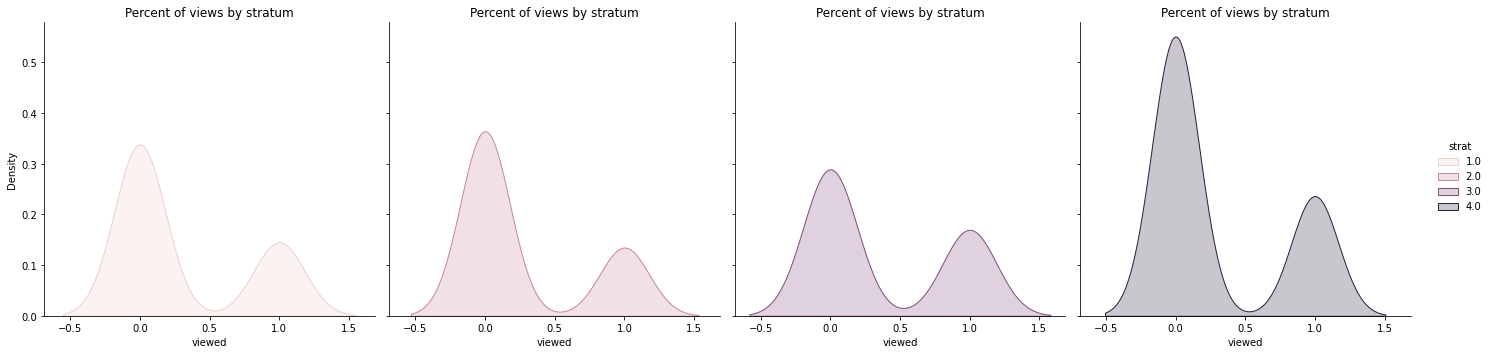

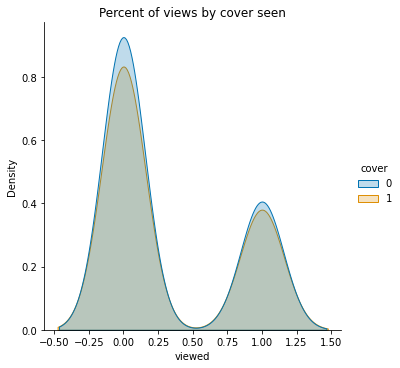

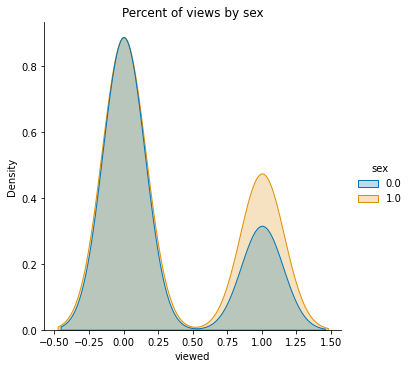

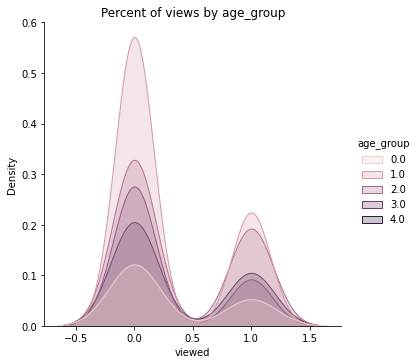

In [77]:
# Visually inspect PDF of well output

savefig=False

# Choosing a color palette suitable for color blind people:
sns.set_palette("colorblind")
#color_pal = sns.color_palette("colorblind", 6).as_hex()
#colors = ','.join(color_pal)

print('Stats by strat:')
print(" strat, not-viewed, viewed ")
for idx in range(1,1+len(stratum)):
    prob_0 = len( df[ (df['strat']==idx) & (df['viewed']==0) ] )
    prob_1 = len( df[ (df['strat']==idx) & (df['viewed']==1) ] )
    prob_tot = prob_0 + prob_1
    print(' {:5}  {:.1%}  {:.1%}'.format(idx, prob_0/prob_tot, prob_1/prob_tot) )
p1 = sns.displot(df, x="viewed", hue="strat", col="strat",
                kind="kde", fill=True)
p1.set(title="Percent of views by stratum")
if savefig: p1.savefig("movie_covers_views_by_stratum.png", dpi=150)

print('\nStats by cover seen:')
print(' cover, %not-viewed, %viewed')
for cov in range(2):
    prob_0 = len( df[ (df['cover']==cov) & (df['viewed']==0)] )
    prob_1 = len( df[ (df['cover']==cov) & (df['viewed']==1)] )
    prob_tot = prob_0 + prob_1
    print(' {:5}  {:.1%}  {:.1%}'.format(cov, prob_0/prob_tot, prob_1/prob_tot) )
p2 = sns.displot(df, x="viewed", hue="cover", #col="proppant",
                kind="kde", fill=True)
p2.set(title="Percent of views by cover seen")
if savefig: p2.savefig("movie_covers_views_by_cover.png", dpi=150)

print('\nStats by sex:')
print(' strat, %not-viewed, %viewed')
for idx in range(2):
    prob_0 = len( df[ (df['sex']==idx) & (df['viewed']==0)] )
    prob_1 = len( df[ (df['sex']==idx) & (df['viewed']==1)] )
    prob_tot = prob_0 + prob_1
    sex = 'M' if idx==0 else 'F'
    print(' {:5}  {:.1%}  {:.1%}'.format(sex, prob_0/prob_tot, prob_1/prob_tot) )
p3 = sns.displot(df, x="viewed", hue="sex", #col="proppant",
                kind="kde", fill=True)
p3.set(title="Percent of views by sex")
if savefig: p3.savefig("movie_covers_views_by_sex.png", dpi=150)

print('\nStats by age:')
print(' age, %not-viewed, %viewed')
age_lims = [0, 25, 35, 45, 55, 120]
for idx in range(len(age_lims)-1):
    #print(idx)
    age_min = age_lims[idx]
    age_max = age_lims[idx+1]
    mask = ( df['age'] >= age_min ) & ( df['age'] < age_max )
    df.loc[ mask, 'age_group'] = idx
    prob_0 = len( df[ (mask) & (df['viewed']==0)] )
    prob_1 = len( df[ (mask) & (df['viewed']==1)] )
    prob_tot = prob_0 + prob_1
    print(' [{:3},{:3})  {:.1%}  {:.1%}'.format(age_min, age_max, prob_0/prob_tot, prob_1/prob_tot) )
p3 = sns.displot(df, x="viewed", hue="age_group", #col="proppant",
                kind="kde", fill=True)
p3.set(title="Percent of views by age_group")
if savefig: p3.savefig("movie_covers_views_by_age_group.png", dpi=150)

- Plot p2 suggests that cover1 has a better performance (higher % of views).
- Plot p3 suggests sex=1 (female) has higher viewing rate.

### Save wells data to file

In [78]:
df.head()

,age,sex,cover,viewed,strat,age_group
0,27.218868,1.0,1,0.0,1.0,1.0
1,21.840064,0.0,0,0.0,1.0,0.0
2,29.001805,0.0,0,0.0,1.0,1.0
3,29.762259,0.0,0,1.0,1.0,1.0
4,18.195859,1.0,0,0.0,1.0,0.0


In [79]:
savedata=False
savedata=True
if savedata:
    df1 = df.drop(columns='strat')
    filename = 'movie_covers.csv'
    df1.to_csv(filename, index=False) # don't include row names
    print("Dataframe saved to file ", filename)
    display( df1.head() )

Dataframe saved to file  movie_covers.csv


,age,sex,cover,viewed,age_group
0,27.218868,1.0,1,0.0,1.0
1,21.840064,0.0,0,0.0,0.0
2,29.001805,0.0,0,0.0,1.0
3,29.762259,0.0,0,1.0,1.0
4,18.195859,1.0,0,0.0,0.0


## Observational estimate

We calculate the average spend of registered customers after they sign up, and compare that with the average spend of customers who didn't sign up.

We will analyse data comparing customers that never signed up (`signup_month=0`) with those that signed up in June (`signup_month=6`). This allows us enough spending data before and after sign-up for a reasonable analysis.

In [80]:
# viewed of sand-drilled wells:
y1 = df.loc[df['cover']==1, "viewed"].mean()
# viewed of ceramic-drilled wells:
y0 = df.loc[df['cover']==0, "viewed"].mean()

est_obs = y1-y0
print("Observational estimate of effect: {:+.1%} views, or {:+.1%} increase for cover=1".format(
    est_obs, est_obs/y0))
print("Observational average views: y1={:.1%} views vs. y0={:.1%} views".format(y1, y0))


Observational estimate of effect: +0.9% views, or +2.8% increase for cover=1
Observational average views: y1=31.3% views vs. y0=30.5% views


According to an simple estimate using the whole set of observed data, ceramic-drilled wells produce 23% more per year than sand-drilled wells.

## Enter DoWhy

To find out a better, less biased estimate of the true causal impact of customer registration on their spend, we will use DoWhy. We start loading the required libraries.

### Building a causal model

We now build a graph incorporating our assumptions on the variables (features) that affect whether a customer *signs up to the programme* as well as the actual amount spent by a customer.

Our assumptions, stemming from our business knowledge, are:
- past expenditure is associated with whether a customer signs up or not: `pre_spend -> treatment`;
- past expenditure is *not* directly associated with future expenditures: no arrow from `pre_spend` to `post_spend`;
- signing up leads to a change (positive or negative) on post-signup spend:  `treatment -> post_spend`;
- more engaged customers will signup earlier ( `signup_month -> program_signup_in_month_i`) and also spend more before (`signup_month -> pre_spend`) and after (`signup_month -> post_spend`) signing up;
- there may be other variables affecting the month in which customers signup (`Z -> program_signup_in_month_i`) that do not directly affect spend before or after signing up;
- it is likely there are further unobserved variables that affect all of `program_signup_in_month_i`, `pre_spend` and `post_spend` ("Unobserved confounders).

In [81]:
df.columns

Index(['age', 'sex', 'cover', 'viewed', 'strat', 'age_group'], dtype='object')

In [82]:
# Propensity score requires Boolean treatment:
treatment='cover'
df[treatment] = df[treatment].astype(bool)
df.head()

,age,sex,cover,viewed,strat,age_group
0,27.218868,1.0,True,0.0,1.0,1.0
1,21.840064,0.0,False,0.0,1.0,0.0
2,29.001805,0.0,False,0.0,1.0,1.0
3,29.762259,0.0,False,1.0,1.0,1.0
4,18.195859,1.0,False,0.0,1.0,0.0


In [83]:
df[treatment].value_counts(dropna=False)

False    233
True     217
Name: cover, dtype: int64

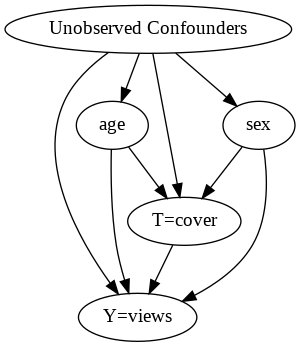

In [84]:
# simple causal graph:
causal_graph = """digraph {
cover[label="T=cover"];
viewed[label="Y=views"];
age;
sex;
U[label="Unobserved Confounders"];
sex -> cover;
age -> cover;
sex -> viewed;
age -> viewed;
cover -> viewed;
U->cover; U->viewed; U->age; U->sex;
}"""
# Instantiate a causal model with the processed data and our causal graph:
model = dowhy.CausalModel(data=df,
                     graph=causal_graph.replace("\n", " "),
                     treatment="cover",
                     outcome="viewed")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

### Identify the causal effect

We assume that `unobserved confounders` do not have an important impact to enable identifying the causal effect:

In [85]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
────────(Expectation(viewed|sex,age))
d[cover]                             
Estimand assumption 1, Unconfoundedness: If U→{cover} and U→viewed then P(viewed|cover,sex,age,U) = P(viewed|cover,sex,age)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
No such variable found!



Here, DoWhy informs us that it can provide estimates of the causal effect using the backdoor criterion, by conditioning on `sex` and `age`.


### Numerical estimate of the causal effect

We now determine the causal estimate of the ATT using *propensity score matching*, i.e., identifying datapoints with similar values of covariates and differing only in the value of *treatment* to estimate the causal effect.

Other potential causal quantities of interest are:

- the *average treatment effect* (ATE):
$ ATE = E[Y(T=1)] - E[Y(T=0)]$

-  the Average Treatment Effect on Control (ATC): $ATC = E[Y(T=1)-Y(T=0)|T=0] =  E[Y(T=1)|T=0] - E[Y(T=0)|T=0]$


In [86]:
# Determine the causal estimate of the ATE

target = 'att'
target = 'ate'

ntot = len(df)
ntreat = df['cover'].sum()
ncontrol = ntot - ntreat
ps_mean = ntreat/ntot
print("Recall the fraction of people that saw cover=1 ", ps_mean)

# PS Matching:
estimate_match = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_matching",
    target_units = target, confidence_intervals=True)

print(estimate_match)
print('********************************\n')

# PS Stratification:
num_strata = 3 # default: 50; note that there will be num_strata+1 strata (range(num_strata))
clipping_threshold = 10 # default: 10
estimate_strat = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_stratification",
    target_units = target,
    confidence_intervals=True,
    method_params={"num_strata": num_strata,
                   "clipping_threshold": clipping_threshold})

print(estimate_strat)
print('********************************\n')

# IPW: I could not determine why none of the methods gives a 
#      reasonable estimate for ATE nor ATT.
#min_ps, max_ps = 0.5 * ps_mean, 2.0 * ps_mean
#min_ps, max_ps = 0.11, 0.68 # after plotting calculated PSs below
min_ps, max_ps = None, None # uses default values: 0.05, 0.95
#min_ps = 0.4277 #406982 # max(ps) in stratum=0
#max_ps = 0.5475 # min(ps) in stratum=4
ipw_method = ["ips_weight", "ips_stabilized_weight", "ips_normalized_weight"]
estimate_ipw = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.propensity_score_weighting",
    target_units = target,
    confidence_intervals=True,
    method_params={"weighting_scheme": ipw_method[0],
                   "min_ps_score": min_ps,
                   "max_ps_score": max_ps,
                   "recalculate_propensity_score": True})

print(estimate_ipw)
print('********************************\n')

#est_causal = estimate.value

print("Causal MATCH estimate of effect: {:+.1%} views, or {:+.1%} for cover=1".format(
    estimate_match.value, estimate_match.value/y0))
print("Causal STRAT estimate of effect: {:+.1%} views, or {:+.1%} for cover=1".format(
    estimate_strat.value, estimate_strat.value/y0))
print("Causal IPW estimate of effect:   {:+.1%} views, or {:+.1%} for cover=1".format(
    estimate_ipw.value, estimate_ipw.value/y0))

print("Recall observational estimate:   {:+.1%} views, or {:+.1%} for cover=1".format(
    est_obs, est_obs/y0))

Recall the fraction of people that saw cover=1  0.4822222222222222
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
────────(Expectation(viewed|sex,age))
d[cover]                             
Estimand assumption 1, Unconfoundedness: If U→{cover} and U→viewed then P(viewed|cover,sex,age,U) = P(viewed|cover,sex,age)

## Realized estimand
b: viewed~cover+sex+age
Target units: ate

## Estimate
Mean value: -0.017777777777777778
95.0% confidence interval: (-0.07333333333333333, 0.07555555555555556)

********************************

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                 
────────(Expectation(viewed|sex,age))
d[cover]                             
Estimand assumption 1, Unconfoundedness: If U→{cover} and U→viewed then P(vi

## Analysis of results

In [87]:
#print("Recall the fraction of wells that were treated is ", num_cer/num_wells)
ntreat = len( df[df['cover']==1] )
ncontrol = len( df[df['cover']==0] )
ntot = ntreat + ncontrol
print("Recall the fraction of customers shown cover1 is {}/{}={:.3f}".format( 
      ntreat, ntot, ntreat / ntot ))

# We can take a look at the propensity scores:
print(
    estimate_strat.propensity_scores.aggregate(['min', 'mean', 'max']),"\n",
    estimate_ipw.propensity_scores.aggregate(['min', 'mean', 'max'])
)


Recall the fraction of customers shown cover1 is 217/450=0.482
min     0.405174
mean    0.482222
max     0.554153
Name: propensity_score, dtype: float64 
 min     0.405174
mean    0.482222
max     0.554153
Name: ps, dtype: float64


In [88]:
display( df.groupby('strata')[['propensity_score', 'age', 'sex']].agg(['min', 'max', 'mean']) )
df.groupby('strata')['strat'].count()

propensity_score                      ...  sex               
                    min       max      mean  ...  min  max      mean
strata                                       ...                    
0.0            0.405174  0.441573  0.425825  ...  0.0  1.0  0.880000
1.0            0.442026  0.486079  0.465094  ...  0.0  1.0  0.624161
2.0            0.486756  0.519602  0.502598  ...  0.0  1.0  0.543046
3.0            0.519606  0.554153  0.531626  ...  0.0  1.0  0.040000

[4 rows x 9 columns]

strata
0.0     75
1.0    149
2.0    151
3.0     75
Name: strat, dtype: int64

DoWhy has built 5 strata:
- stratum 0 is formed by 56 males (sex=0), of older age; as there are no women, propensity score is on the lower range (<0.40);
- stratum 5 is formed by 57 females (sex=1), of young age; as there are no men, propensity score is on the higher range (>0.5370);
- strata 1-3 have a mix of sexes and ages, and larger numbers;

We will use only strata 1-3, hence set min_ps and max_ps accordingly.

In [89]:
ps_cuts = df.groupby('strata')['propensity_score'].min()
ps_cuts

strata
0.0    0.405174
1.0    0.442026
2.0    0.486756
3.0    0.519606
Name: propensity_score, dtype: float64

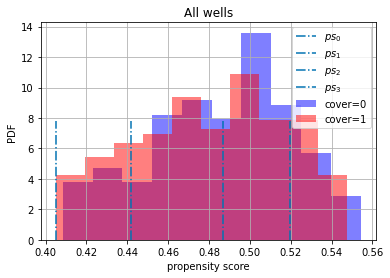

In [90]:
idx_ctrl = df.index[ df['cover']==0 ]
idx_treat = df.index[ df['cover']==1 ]

ps_treat = estimate_strat.propensity_scores.loc[idx_treat]
ps_ctrl = estimate_strat.propensity_scores.loc[idx_ctrl]
#ps_ctrl_1 = ps_ctrl [ps_ctrl>ps_thr]

#ps_cut_1 = 0.43
#ps_cut_2 = 0.53

fig, ax0 = plt.subplots(1,1)
#fig, (ax0, ax1) = plt.subplots(1,2, figsize=(8,3))
ps_treat.hist(ax=ax0, color='blue', alpha=0.5, label='cover=0', density=True)
ps_ctrl.hist(ax=ax0, color='red', alpha=0.5, label='cover=1', density=True)

for idx, cut in enumerate(ps_cuts):
    lab = '$ps_{:1}$'.format(idx)
    ax0.axvline(x=cut, ymin=0, ymax=ps_ctrl.max(), linestyle='-.', label=lab)
ax0.set_xlabel('propensity score')
ax0.set_ylabel('PDF');
ax0.set_title('All wells');
ax0.legend()
plt.legend()
#plt.xlabel('propensity score')
#plt.ylabel('PDF');
#fig.tight_layout() #pad=3.0)

# fig.savefig("movie_covers_ps.png", dpi=150)

### Refuting the causal estimate

We emphasize again that the causal estimate does not come from data alone. It comes from our assumptions (represented in the causal graph), which underpin the identification step. 

Data is simply used for statistical estimation. Thus it becomes critical to verify whether our assumptions were even correct in the first step or not!

A first-principles verification of assumptions is out of the question, but we can subject our results to a number of refutation attempts -- if all come back as expected, we gain confidence that our causal graph is a good representation of the real-world situation.

We now describe some of the refutation methods available on DoWhy:

- *Placebo Treatment Refuter*: Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [91]:
estimate = estimate_strat

refute_placebo = model.refute_estimate(identified_estimand, 
                                   estimate, 
                                   method_name="placebo_treatment_refuter",
                                   placebo_type="permute", num_simulations=2)
print(refute_placebo)

Refute: Use a Placebo Treatment
Estimated effect:0.006173838859523785
New effect:0.03948174897085797
p value:8.220588848638266e-278



We see that the new effect with the placebo ($\approx 0.05$) is much closer to zero than the initial estimate ($\approx 0.26$), reinforcing our confidence in it.

- *Random Common Cause*: Adds randomly drawn covariates to the data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [92]:
refute_common_cause=model.refute_estimate(identified_estimand, 
                                          estimate,
                                          method_name="random_common_cause")
print(refute_common_cause)

Refute: Add a Random Common Cause
Estimated effect:0.006173838859523785
New effect:0.0062847880769820305



The new estimate is similar to the initial one which suggests that it is not a random coincidence (it is robust to adding random noise).

- *Data Subset Refuter*: Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [93]:
# Note: default value for num_simulations = 100, which can take a long time
refute_subset=model.refute_estimate(identified_estimand,
                                    estimate,
                                    method_name="data_subset_refuter",
                                    num_simulations=3)
print(refute_subset)

Refute: Use a subset of data
Estimated effect:0.006173838859523785
New effect:-0.017066567064394696
p value:0.1856343753321935



*Conclusion:*
We see that our estimate passes all three refutation tests. This does not prove its correctness, but it increases confidence in the estimate.

## Acknowledgement

This introductory notebook has been motivated by 
A. Bertoncello et al., "Using Causal Inference in Field Development Optimization: Application to Unconventional Plays", [Math Geosci (2020) 52:619–635](https://doi.org/10.1007/s11004-019-09847-z)